# **NFTs Prices Prediction - Seminar Project**

This is a seminar project that tries to predict the price of nfts of 100+ collections (a collection is a set of NFTs released by a creator)
The main data sets were taken from kaggle https://www.kaggle.com/datasets/eyenpi/solana-nft-collections)
The data sets are combined from: 
1) a general data set that contains information about the collection 
2) a directory that contains datasets about every NFT each collection

I also combined more data sets from various sources including Twitter, OpenSea, Investing.com in order to get more features that can help us predict the prices of each and every NFT

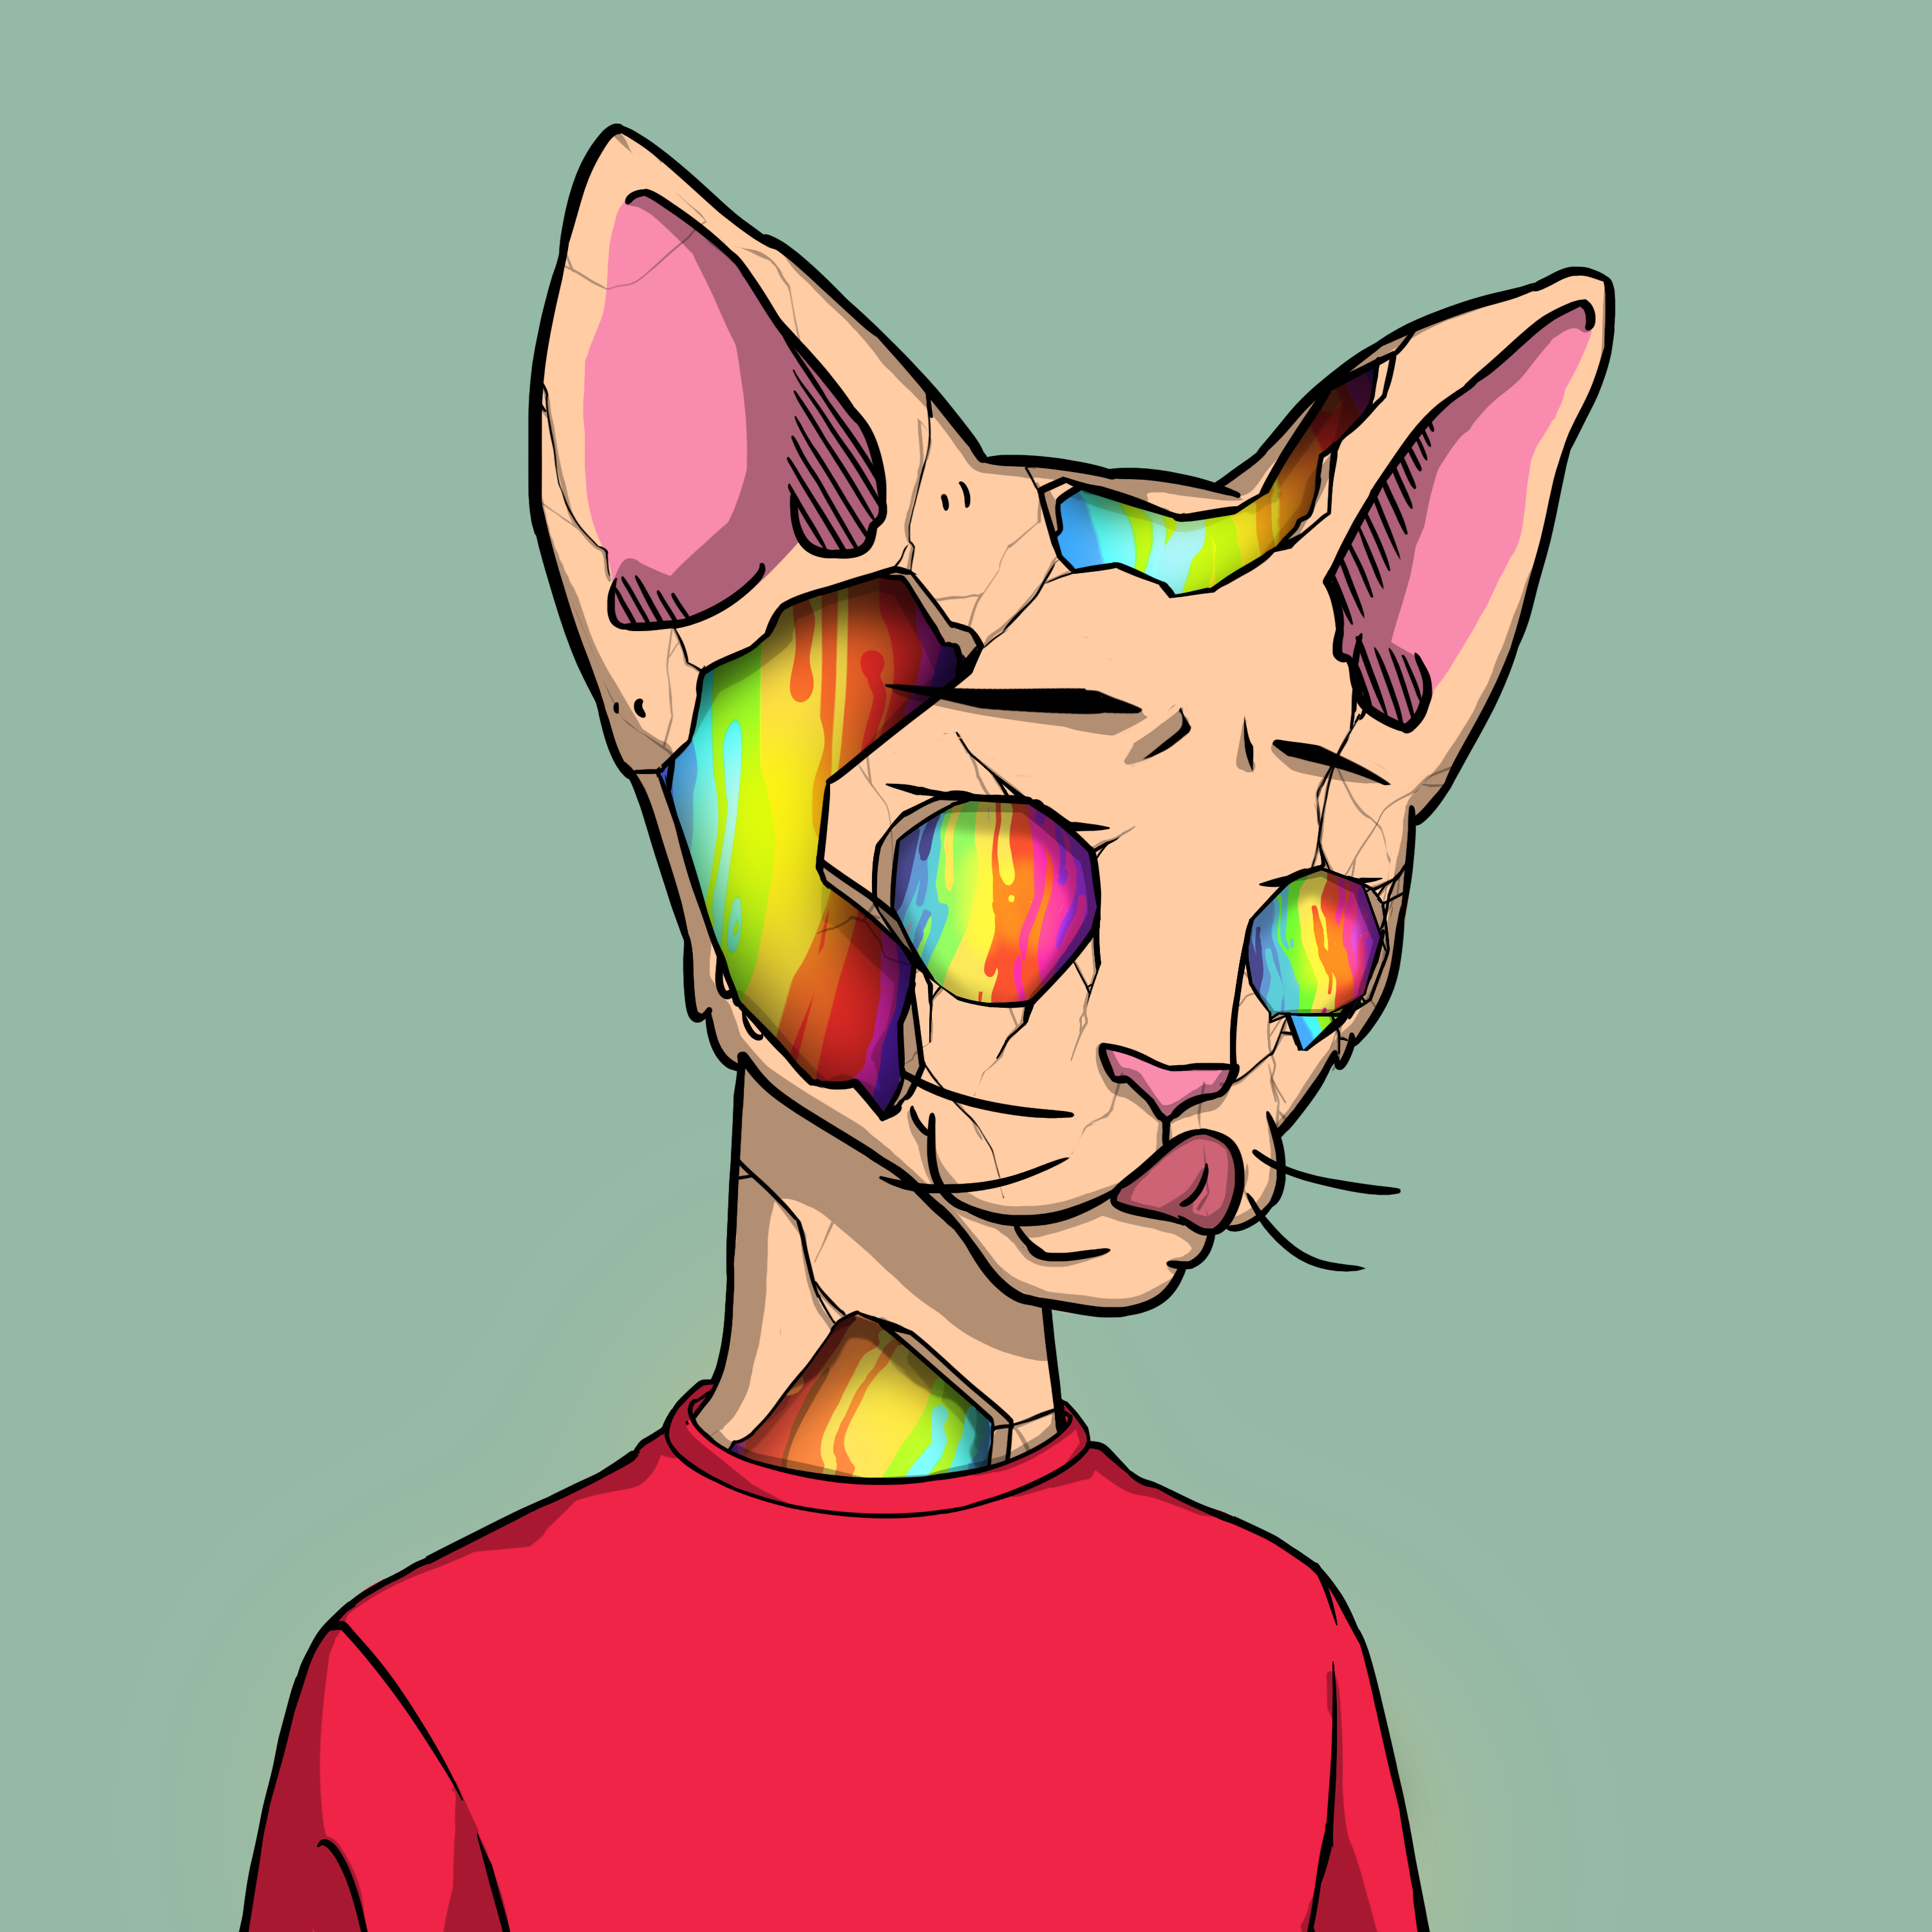

In [68]:
display.Image("MvVT1-2e0vk5rN4LMJPHqNogwFoLxAvg0FgNPaeD4cU.png", width = 400)

## Imports

In [1]:
import os
import pandas as pd
import numpy as np
import os
from tqdm import tqdm
import PIL.Image
from PIL import UnidentifiedImageError
import requests
from io import BytesIO
from pathlib import Path
from PIL import UnidentifiedImageError, Image
import datetime as dt
import time
import itertools
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import AdaBoostRegressor
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from multiprocessing import *
import time 
import sys
import requests
from sklearn import metrics
from sklearn.dummy import DummyRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error
import seaborn as sn
import pandas as pd
import warnings
import urllib.request
import numpy as np
import cv2
import warnings
from IPython.display import Image
import datetime
import math
import missingno
import pandas_profiling
import IPython
warnings.filterwarnings("ignore")


We merge all the 100+ datasets into one dataset

In [2]:
collections = pd.read_csv("collections.csv")
datasets = []
dataset_len = {}

for dataset_name,i in zip(collections['symbol'], range(len(collections))):
    dataset_name = pd.read_csv("Collections/"+dataset_name+".csv")
    dataset_name['collectionsImage']= collections.iloc[i, collections.columns.get_loc('image')]
    dataset_name['collectionCreatedAt']=  collections.iloc[i, collections.columns.get_loc('createdAt')]
    dataset_name['collectionUpdatedAt'] = collections.iloc[i, collections.columns.get_loc('updatedAt')]
    for col in ['candyMachineIds','categories', 'description', 'enabledAttributesFilters','isDraft', 'website', 'twitter', 'discord', 'derivativeDetails','isDerivative', 'nftImageType', 'totalItems', '__v','flagMessage', 'isFlagged', 'rarity']:
        dataset_name[col] = collections.iloc[i, collections.columns.get_loc(col)]
    datasets.append(dataset_name)
df = pd.concat(datasets)

Merging datasets from outer sources - by date

In [3]:
def date_to_epoch(date):
  try:
    date = str(date)
    month, day, year = date.split('/')
    if month[0] == '0':
      month = str(month[1])
    if day[0] == '0':
      day = str(day[1])  
    return (datetime.datetime(int(year),int(month),int(day)) - datetime.datetime(1970,1,1)).total_seconds()
  except:
    return np.nan

def date_formatting(date):
  date = str(date)
  if date != np.nan:
    day,month, year = date.split('/')
    return f'{day}/{month}/{year}'
  else:
    return np.nan

def date_formatting1(date):
  date = str(date)
  if date != np.nan:
    day,month,year = date.split('-')
    return f'{day}/{month}/{year}'
  else:
    return np.nan

def date_formatting2(date):
  date = str(date)
  if date != np.nan:
    day,month,year = date.split('/')
    return f'{month}/{day}/{year}'
  else:
    return np.nan

#Merging data sets from various sources 
df1 = pd.read_csv('twitter data.csv')
df3 = pd.read_csv('NFT_Sales (1).csv')
df5 = pd.read_csv("collection_data.csv")
df7 = pd.read_csv("SOL-USD (2).csv")
df9 = pd.read_csv("sol_daily_sentiment.csv")
df10=pd.read_csv("social fear gread  index.csv")
df.rename(columns={"collectionCreatedAt": "Date"}, inplace=True)
df['Date'] = pd.to_datetime(df['Date']).dt.strftime('%m/%d/%Y')
df9.rename(columns={"date1": "Date"}, inplace=True)
df9['Date'] = pd.to_datetime(df9['Date']).dt.strftime('%m/%d/%Y')
df10.rename(columns={"date1": "Date"}, inplace=True)
df10['Date'] = pd.to_datetime(df10['Date']).dt.strftime('%m/%d/%Y')
df7['date'] = df7['date'].apply(date_formatting2)
df7.rename(columns={"date": "Date"}, inplace=True)
df['collectionUpdatedAt'] = pd.to_datetime(df['collectionUpdatedAt']).dt.strftime('%m/%d/%Y')
df3['Date'] = pd.to_datetime(df3['Date']).dt.strftime('%m/%d/%Y')
df_1=pd.merge(df,df3,on='Date',how='left')
df_1=pd.merge(df_1,df1,on='collectionName',how='left')
df_1=pd.merge(df_1, df5, on= 'collectionName', how = 'left')
df_1 = pd.merge(df_1, df7, on= 'Date', how = 'left')
df_1 = pd.merge(df_1, df9, on= 'Date', how = 'left')
df_1 = pd.merge(df_1, df10, on= 'Date', how = 'left')
df_1['Date'] = df_1['Date'].apply(date_to_epoch)
df_1['collectionUpdatedAt'] = df_1['collectionUpdatedAt'].apply(date_to_epoch)

In [4]:
df_1.head()

Unnamed: 0_x                                            id  price  \
0             0  ChXDGUBThc8frb7qsoUdiSZLpSGjhXhaK2U13pzDk3w4   1.35   
1             1  DXywnmhtsPiob913Q8WYwEL37YkCEGBH4zXH7TRnUvSp   1.47   
2             2   E1eQxXxBb7TYneHcvx1ZBUAnhSw1WyXcyc9uJaQB4WC   1.49   
3             3  8ARxCQEsvYQLQxoFDHvbQXhABgqMrAohr2b1SvwMhY9x   1.50   
4             4  GrzQAfPNzqLhmSG7ox5EnGynqkxCom27EMJHoPJAmYBf   1.50   

                                   escrowPubkey  \
0  9JLWWXuMoH7goCXjssVf6qpSbDhHhJrFMkdZ5Zsw1v3m   
1  8h7gnPK4SsfSH6rvKwVzvUi22TwQAcfxehdiYH8AmNrV   
2  AHJq4GbztGwvVjkewSJcaSNcdQUq2G3qXib4UbxbEoLb   
3  FVGkAd35hKDUkDLnDh17q4CdGpo6zmYCjNm7GqiUats2   
4  HsSsAV73KAxfe13an69cSP6g7arnQKaZF98s6DSV5CUf   

                                          owner     collectionName  \
0  5cF6M4b1GEjzqBPJvAh5FqVmcerJabadtH4amjQUQnfu  guild_saga_heroes   
1  ARxzW9chM1wNFFGMWxvakCP86JB1KUiHm31dCEvJcJyx  guild_saga_heroes   
2  29eZ5Vt7v9YXSUmU3VkAnZomqaziyCfjJiFa2VygkCVd  guild_saga_heroes   
3  GZoe9o1VvY5io6A4CgkTDQ53E3XSXM2odTjhCxiJUfsC  guild_saga_heroes   
4  2Q3mcDLuXDHNG3oAaMA4uPpemwkS3kFtBmaCxq1p1fzd  guild_saga_heroes   

     collectionTitle                                                img  \
0  Guild Saga Heroes  https://gldhero-production.s3.amazonaws.com/72...   
1  Guild Saga Heroes  https://gldhero-production.s3.amazonaws.com/50...   
2  Guild Saga Heroes  https://gldhero-production.s3.amazonaws.com/22...   
3  Guild Saga Heroes  https://gldhero-production.s3.amazonaws.com/82...   
4  Guild Saga Heroes  https://gldhero-production.s3.amazonaws.com/27...   

              title                                            content  ...  \
0  Guild Hero #7200  A humble member of the Heroes Guild and fated ...  ...   
1   Guild Hero #509  A humble member of the Heroes Guild and fated ...  ...   
2  Guild Hero #2257  A humble member of the Heroes Guild and fated ...  ...   
3  Guild Hero #8229  A humble member of the Heroes Guild and fated ...  ...   
4  Guild Hero #2778  A humble member of the Heroes Guild and fated ...  ...   

  total_volume       Open       High        Low      Close  Adj Close  \
0       628.34  89.228134  94.777809  87.276161  92.598824  92.598824   
1       628.34  89.228134  94.777809  87.276161  92.598824  92.598824   
2       628.34  89.228134  94.777809  87.276161  92.598824  92.598824   
3       628.34  89.228134  94.777809  87.276161  92.598824  92.598824   
4       628.34  89.228134  94.777809  87.276161  92.598824  92.598824   

       Volume ticker  sentiment Social Fear and Greed Index  
0  3069242551    SOL    0.23489                   19.958392  
1  3069242551    SOL    0.23489                   19.958392  
2  3069242551    SOL    0.23489                   19.958392  
3  3069242551    SOL    0.23489                   19.958392  
4  3069242551    SOL    0.23489                   19.958392  

[5 rows x 79 columns]

In [5]:
print("Our dataset now has:")
print(str(df_1.shape[0]) + " rows")
print(str(len(df_1.columns)) + " columns")

Our dataset now has:
45167 rows
79 columns


In [6]:
df_1.describe()

Unnamed: 0_x         price  sellerFeeBasisPoints   supply  \
count  45167.000000  4.516700e+04          45167.000000  45167.0   
mean     375.117630  2.596914e+02            702.178360      1.0   
std      379.283222  1.595570e+04            234.052466      0.0   
min        0.000000  1.399000e-01            300.000000      1.0   
25%      103.000000  2.256333e+00            500.000000      1.0   
50%      246.000000  6.000000e+00            700.000000      1.0   
75%      518.000000  1.690000e+01            888.000000      1.0   
max     1953.000000  2.000000e+06           1500.000000      1.0   

       primarySaleHappened          Date  collectionUpdatedAt  isDraft  \
count         45167.000000  4.516700e+04         3.574000e+04  39462.0   
mean              0.975889  1.645096e+09         1.649316e+09      0.0   
std               0.153394  5.137696e+06         1.548784e+06      0.0   
min               0.000000  1.632614e+09         1.643328e+09      0.0   
25%               1.000000  1.643414e+09         1.648944e+09      0.0   
50%               1.000000  1.646870e+09         1.650240e+09      0.0   
75%               1.000000  1.649376e+09         1.650240e+09      0.0   
max               1.000000  1.650154e+09         1.650240e+09      0.0   

       isDerivative    totalItems  ...  thirty_day_average_price  \
count  39379.000000  28099.000000  ...              26063.000000   
mean       0.018716   4292.861419  ...                  0.286741   
std        0.135520   3519.664418  ...                  0.741655   
min        0.000000      0.000000  ...                  0.000000   
25%        0.000000      0.000000  ...                  0.000000   
50%        0.000000   4420.000000  ...                  0.050000   
75%        0.000000   6660.000000  ...                  0.140000   
max        1.000000  10009.000000  ...                  6.770000   

       total_volume          Open          High           Low         Close  \
count  26063.000000  45167.000000  45167.000000  45167.000000  45167.000000   
mean     912.017197    114.017375    119.425860    110.201873    114.793748   
std     1479.163662     32.824485     34.866034     31.469840     34.298918   
min        0.000000     78.925575     82.099304     76.859573     78.936073   
25%        0.000000     88.741905     93.766808     87.276161     90.512970   
50%      346.290000    101.298691    109.117561     99.256844    102.257317   
75%     1260.670000    122.736107    137.558411    118.787910    131.537216   
max    12591.330000    243.097809    250.466339    235.150879    247.387772   

          Adj Close        Volume     sentiment  Social Fear and Greed Index  
count  45167.000000  4.516700e+04  32338.000000                 33524.000000  
mean     114.793748  2.243483e+09      0.256949                    47.881956  
std       34.298918  9.169830e+08      0.107620                    28.708160  
min       78.936073  7.749393e+08     -0.115100                     0.225326  
25%       90.512970  1.690398e+09      0.176160                    24.537560  
50%      102.257317  2.196400e+09      0.274510                    44.349989  
75%      131.537216  2.440063e+09      0.334540                    73.949656  
max      247.387772  6.865815e+09      0.457680                    99.770151  

[8 rows x 45 columns]

In [7]:
df_1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 45167 entries, 0 to 45166
Data columns (total 79 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Unnamed: 0_x                  45167 non-null  int64  
 1   id                            45167 non-null  object 
 2   price                         45167 non-null  float64
 3   escrowPubkey                  45167 non-null  object 
 4   owner                         45167 non-null  object 
 5   collectionName                45167 non-null  object 
 6   collectionTitle               45167 non-null  object 
 7   img                           45167 non-null  object 
 8   title                         45167 non-null  object 
 9   content                       42645 non-null  object 
 10  propertyCategory              41308 non-null  object 
 11  creators                      45167 non-null  object 
 12  sellerFeeBasisPoints          45167 non-null  int64  
 13  m

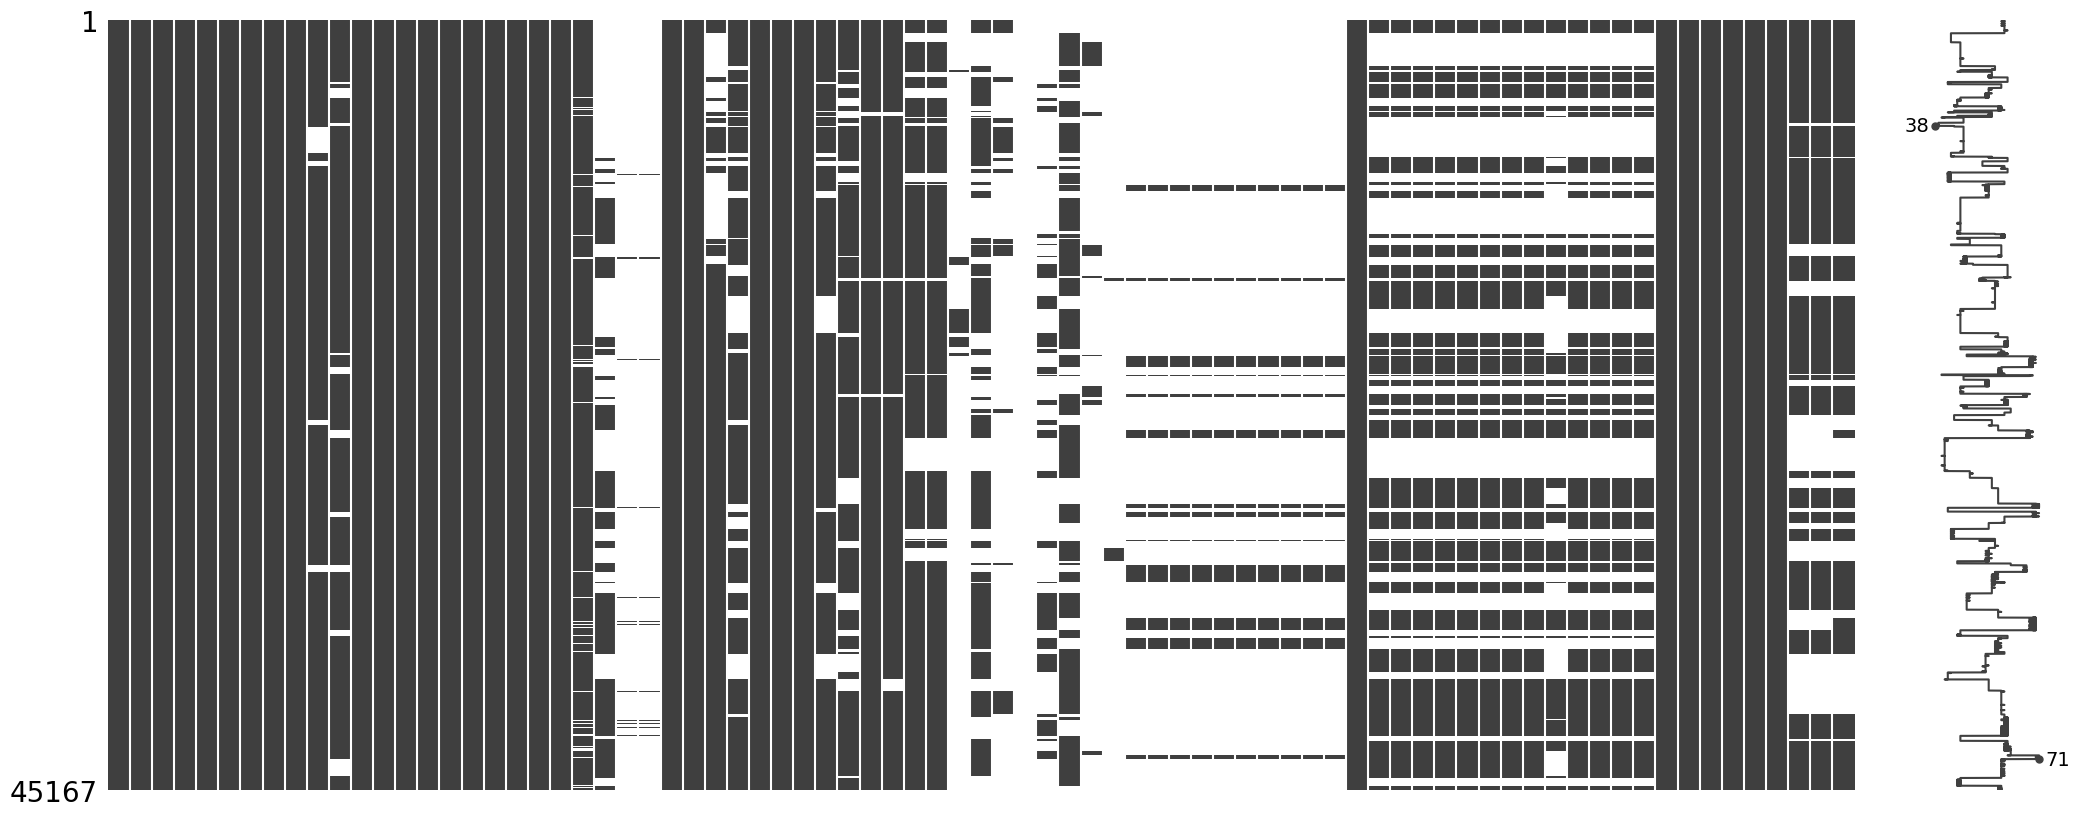

In [8]:
missingno.matrix(df_1)
plt.show()

Let's start removing unnecessary columns

In [9]:
#delete columns with no varience
for col in df_1.columns:
  if df_1[col].nunique() == 1 or df_1[col].nunique() == 0:
    print(col)
    df_1.drop(col, axis =1, inplace = True)

supply
tokenDelegateValid
v2
tokenDelegate
enabledAttributesFilters
isDraft
__v
flagMessage
isFlagged
ticker


In [10]:
# Removing rows that has a null value in total_sales column                   
df_1.dropna(subset = ['total_sales'], inplace=True)

In [11]:
# Removing columns that more than half of their values are Null
null_lst = df_1.isnull().sum().divide(df_1.shape[0])
null_lst= null_lst[null_lst > 0.5].sort_values(ascending = False)
print(null_lst)
for feat in null_lst.keys():
  df_1.drop(feat, axis = 1, inplace = True)

extern                          0.977900
nftImageType                    0.974523
imgCDN                          0.969037
animationURL                    0.933546
Sales_USD_cumsum                0.876990
Number_of_Sales_cumsum          0.876990
Active_Market_Wallets_cumsum    0.876990
Primary_Sales_cumsum            0.876990
Secondary_Sales_cumsum          0.876990
AverageUSD_cum                  0.876990
Sales_USD                       0.876990
Number_of_Sales                 0.876990
Active_Market_Wallets           0.876990
Primary_Sales                   0.876990
dtype: float64


In [12]:
#ids and adressess are generated randomly, thus, they cannot affect the nft price
df_1.drop(['collectionTitle', 'id', 'escrowPubkey','attributes', 'onChainCollection', 'owner','content','creators','collectionsImage', 'externalURL','properties','updateAuthority','title', 'mintAddress', 'candyMachineIds', 'description', 'twitter', 'website', 'discord', 'derivativeDetails', 'rarity', 'Unnamed: 0_x', 'Unnamed: 0_y'], axis = 1, inplace = True)

#### Categorical Features Encoding

There's a column in our dataset called "categories", its values are very hard to encode.

In [13]:
df_1['categories'].sample(5).head()

8921     ['launchpad']
44935         ['pfps']
3176          ['pfps']
22887    ['launchpad']
24223         ['pfps']
Name: categories, dtype: object

In [14]:
#OHE for categories column
categories = df_1['categories'].value_counts().keys()
cat_list = []
for cat in categories:
  temp = cat[1:-1].replace("'","").replace(" ", "").split(',')
  cat_list.extend(temp)
cat_list= list(dict.fromkeys(cat_list))
del cat_list[4]

for item in cat_list:
  df_1[item] = 0
for index in tqdm(range(len(df_1))):
  for col in cat_list:
    if col in df_1.iloc[index]['categories']:
      df_1.iat[index, df_1.columns.get_loc(col)] = 1

100%|██████████| 26063/26063 [01:10<00:00, 369.55it/s]


In [15]:
df_1 = df_1.join(pd.get_dummies(df_1.propertyCategory, prefix=''))

In [16]:
# Dropping categorical columns after uncoding them
propertyCategory = df_1.propertyCategory #we're gonna use it for later visualization

df_1.drop(['categories', 'propertyCategory'], axis =1, inplace = True)

#### Converting the target from SOL into USD 

In [17]:
# We convert it now in order to have better visualization of target distribution. Is also used calculated during preprocessing
df_1['mean_sol_value'] = (df_1['Open']+df_1['Close'])/2
df_1['mean_sol_value']
df_1['adj_price'] = df_1['price']*df_1['mean_sol_value']
df_1['adj_price']
df_1.drop(['Open', 'Close'], axis = 1, inplace = True)

In [18]:
propertyCategory_df = pd.concat([propertyCategory, df_1['adj_price']], axis=1) #we're gonna use it for later visualization

## Description of Features Remained

In [19]:
description = {'Desctiption': ['NFT price in solana','the name of the collection', 'the url to the photo of the NFT','the fee the seller paid when he bought the NFT','is the collection had a primary sale','the date the collection was launched', 'the date the collection was updated','is the property derieved','the number of items in the collection', 'the number of followers the creator of the NFT has','total sales of NFT in the collection','the total number of NFTs supplied in the collection','?','trade volume in the collection in the past 30 days','total sales in the collection in the past 30 days','the number of owners that hold NFT from the collection ','?','?','the total market cap of the collection', 'the average price of asset in the collection', 'the average price of the asset in the past 30 days','the total volume of sales in the collection in the past 30 days','the highest price of solana in the day the collection launched', 'the lowest price of solana in the day the collection was launched','the close price after adjustments', 'the trade volume in solana in the day', 'the sentiment of the market towards solana in the day sold (scale of 0 to 1) the higher - the more positive','an index that describes the market fear and greed towards ctyptocurrencies', 'is the NFT a profile picture', 'is the photo artistic', '?', 'is the nft related to virtual world', 'is the nft related to games', 'is the nft related to sports', 'is the nft related to photography', 'is the nft an image', 'is the nft a video', 'mean solana price on day of launch', 'price of nft in dollars on the day of launch']} 
desc = pd.DataFrame(description, index=df_1.columns.to_list())
desc

Desctiption
price                                                      NFT price in solana
collectionName                                      the name of the collection
img                                            the url to the photo of the NFT
sellerFeeBasisPoints            the fee the seller paid when he bought the NFT
primarySaleHappened                       is the collection had a primary sale
Date                                      the date the collection was launched
collectionUpdatedAt                        the date the collection was updated
isDerivative                                          is the property derieved
totalItems                               the number of items in the collection
number_of_followers          the number of followers the creator of the NFT...
total_sales                               total sales of NFT in the collection
total_supply                 the total number of NFTs supplied in the colle...
num_reports                                                                  ?
thirty_day_volume            trade volume in the collection in the past 30 ...
thirty_day_sales             total sales in the collection in the past 30 days
num_owners                   the number of owners that hold NFT from the co...
count                                                                        ?
floor_price                                                                  ?
market_cap                              the total market cap of the collection
average_price                     the average price of asset in the collection
thirty_day_average_price     the average price of the asset in the past 30 ...
total_volume                 the total volume of sales in the collection in...
High                         the highest price of solana in the day the col...
Low                          the lowest price of solana in the day the coll...
Adj Close                                    the close price after adjustments
Volume                                   the trade volume in solana in the day
sentiment                    the sentiment of the market towards solana in ...
Social Fear and Greed Index  an index that describes the market fear and gr...
pfps                                              is the NFT a profile picture
art                                                      is the photo artistic
launchpad                                                                    ?
virtual_worlds                             is the nft related to virtual world
games                                              is the nft related to games
sports                                            is the nft related to sports
photography                                  is the nft related to photography
_image                                                     is the nft an image
_video                                                      is the nft a video
mean_sol_value                              mean solana price on day of launch
adj_price                         price of nft in dollars on the day of launch

# Visulaizations

histogram for price


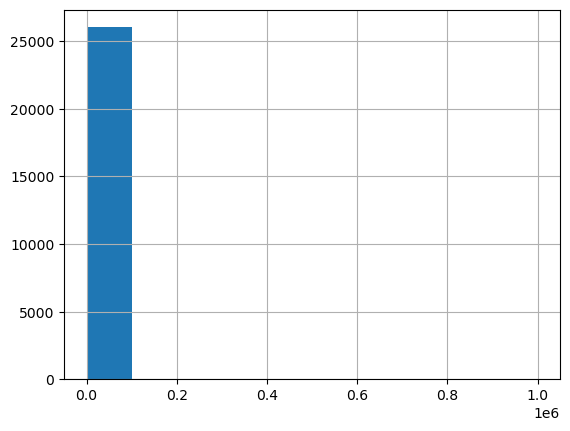

histogram for sellerFeeBasisPoints


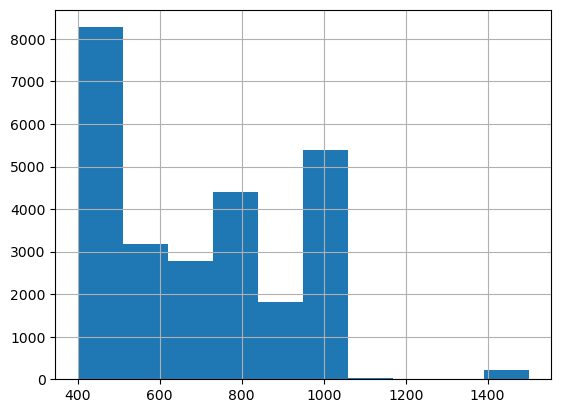

histogram for primarySaleHappened


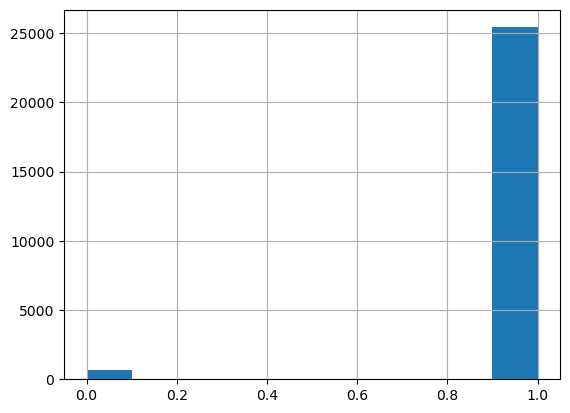

histogram for Date


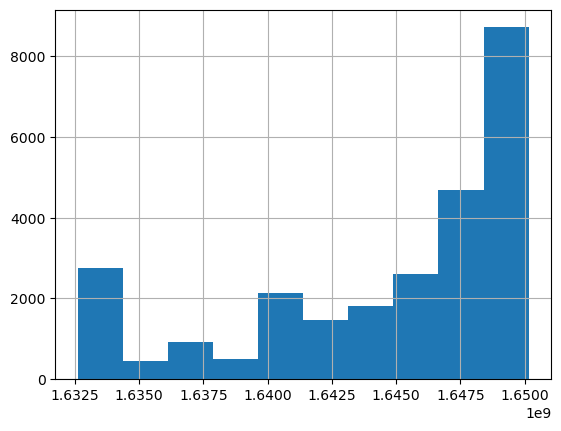

histogram for collectionUpdatedAt


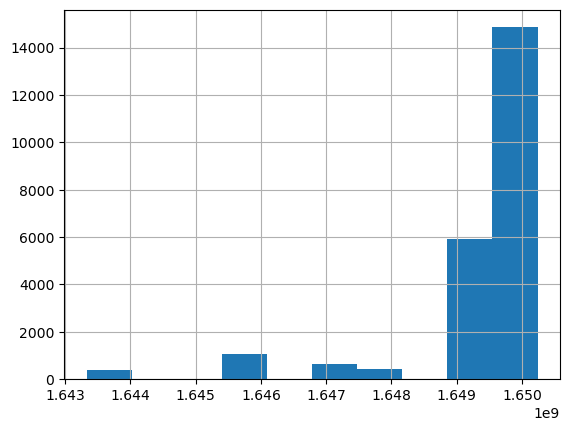

histogram for isDerivative


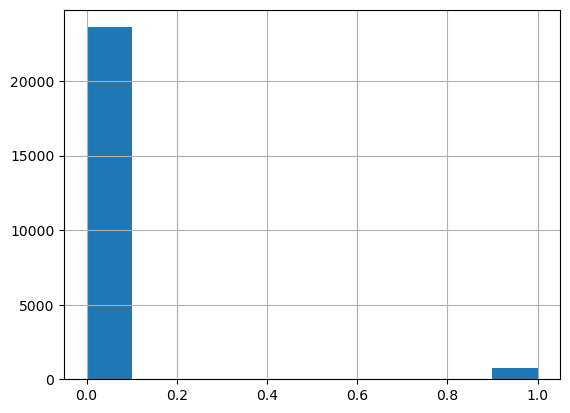

histogram for totalItems


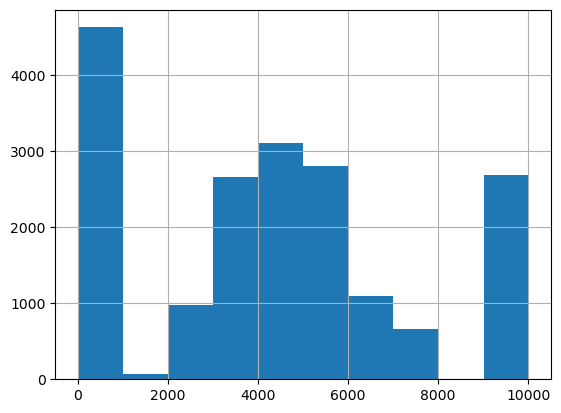

histogram for number_of_followers


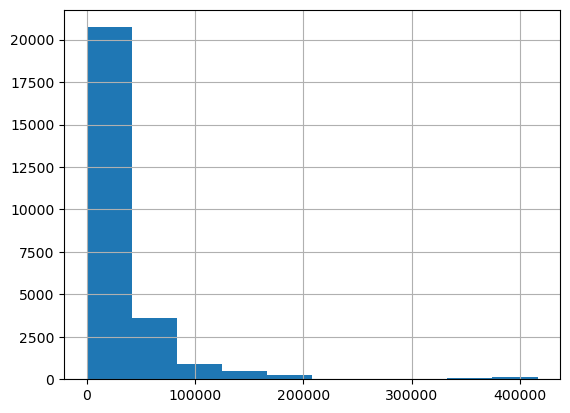

histogram for total_sales


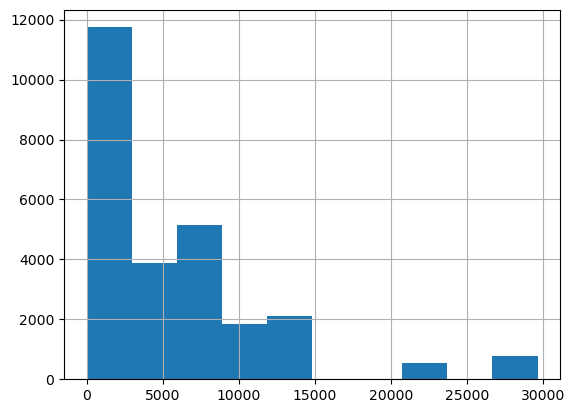

histogram for total_supply


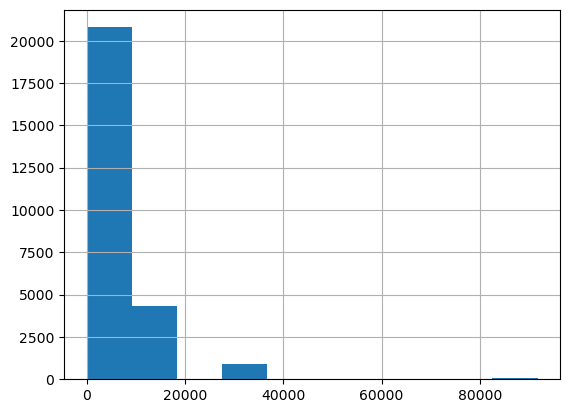

histogram for num_reports


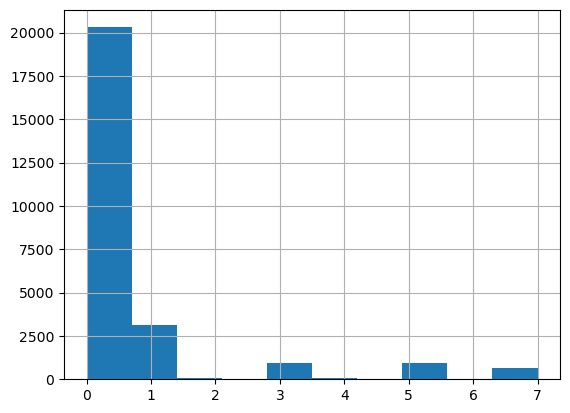

histogram for thirty_day_volume


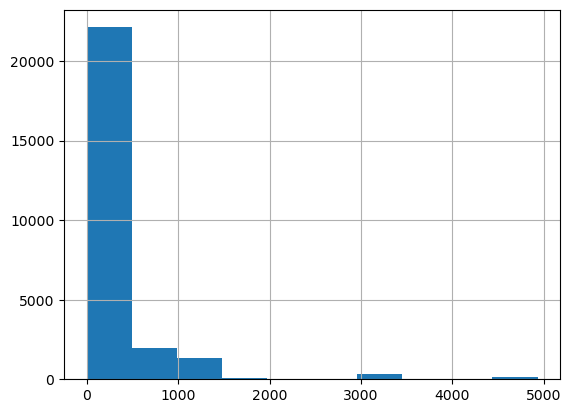

histogram for thirty_day_sales


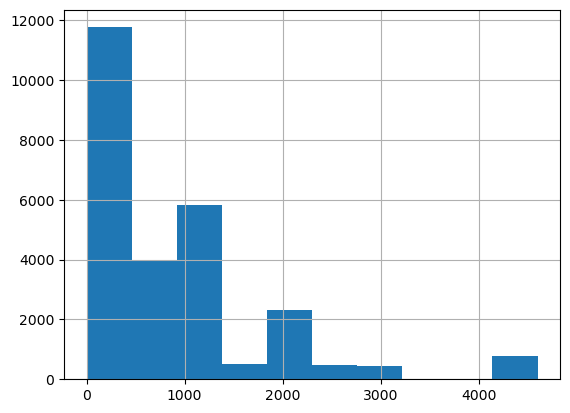

histogram for num_owners


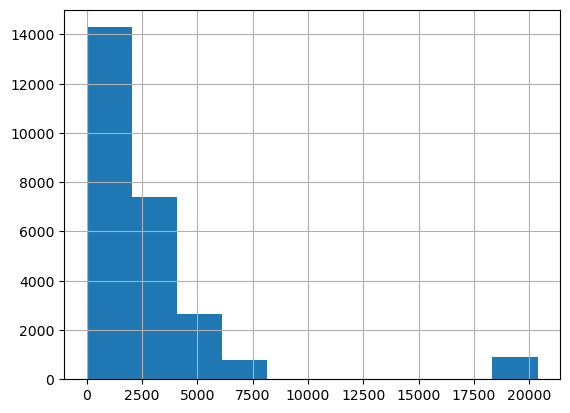

histogram for count


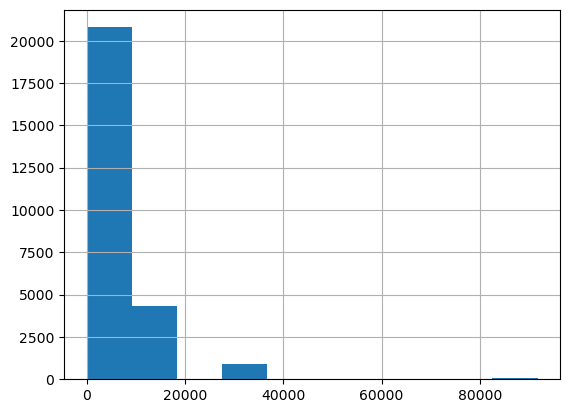

histogram for floor_price


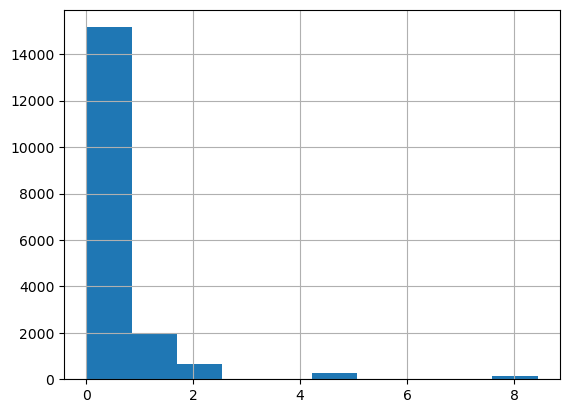

histogram for market_cap


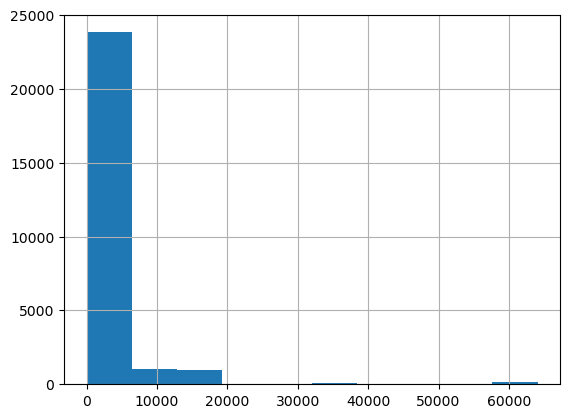

histogram for average_price


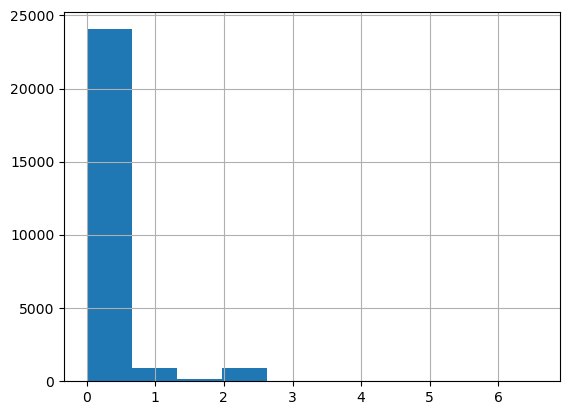

histogram for thirty_day_average_price


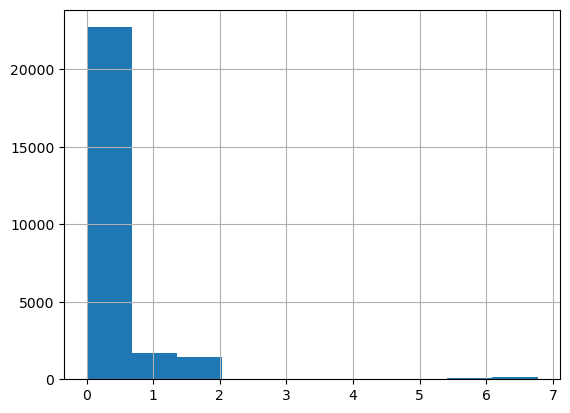

histogram for total_volume


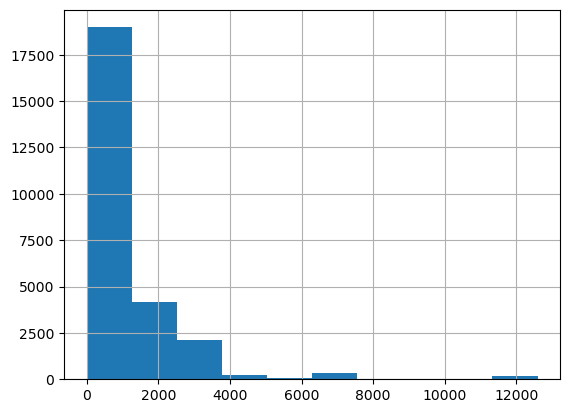

histogram for High


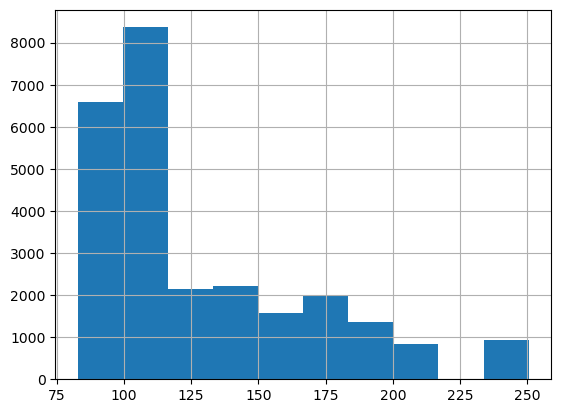

histogram for Low


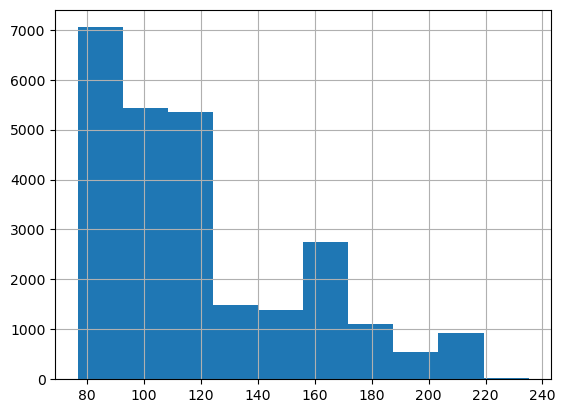

histogram for Adj Close


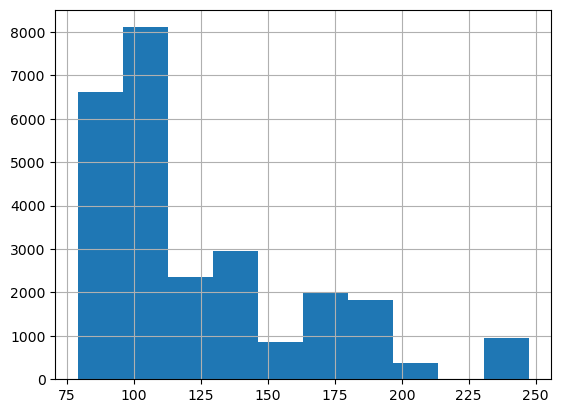

histogram for Volume


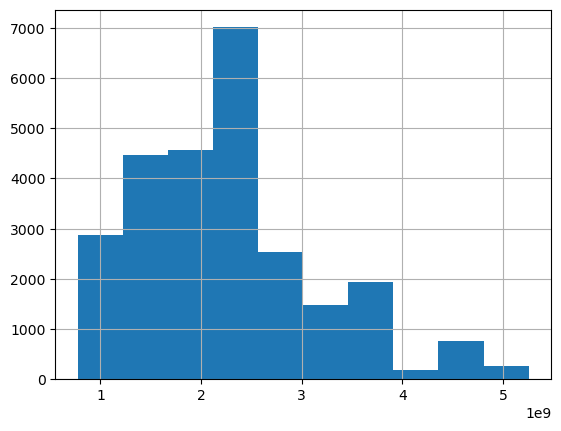

histogram for sentiment


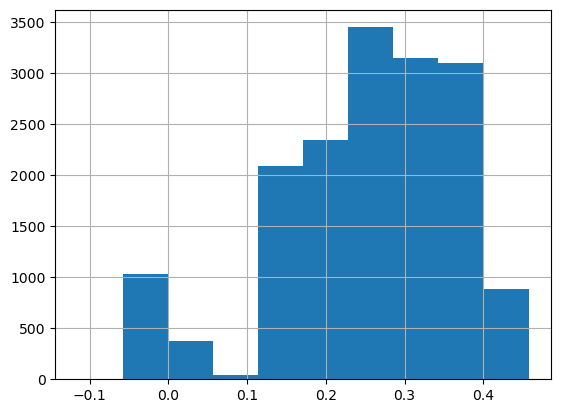

histogram for Social Fear and Greed Index


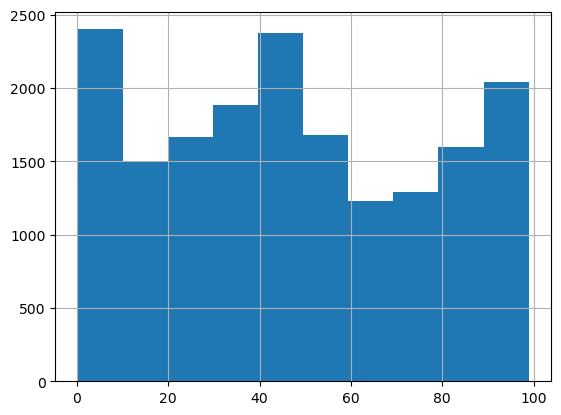

histogram for pfps


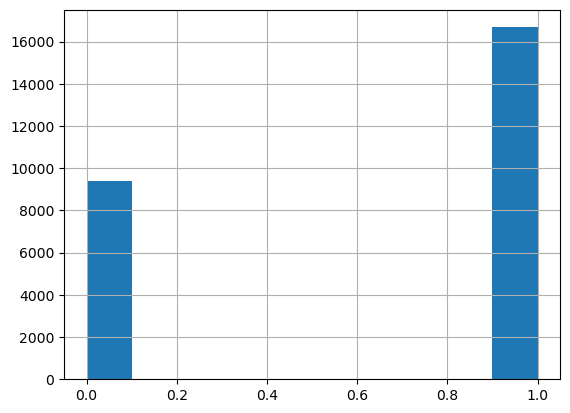

histogram for art


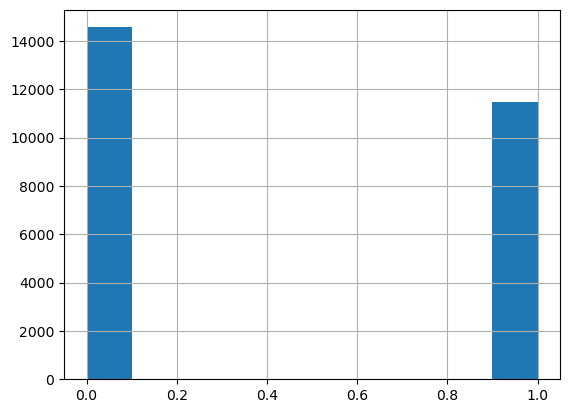

histogram for launchpad


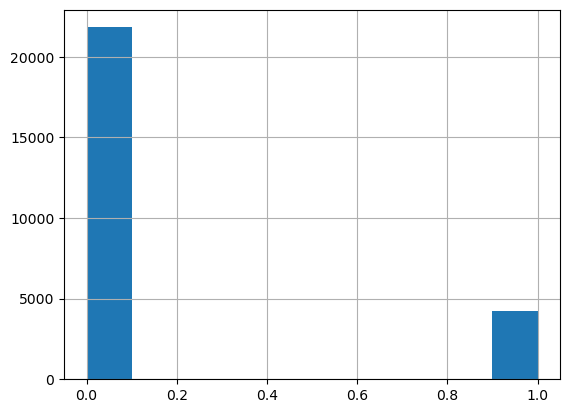

histogram for virtual_worlds


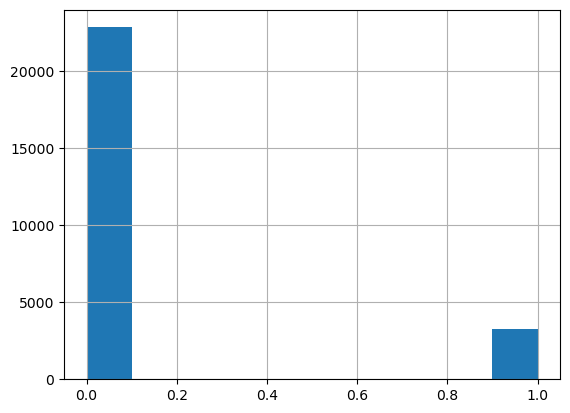

histogram for games


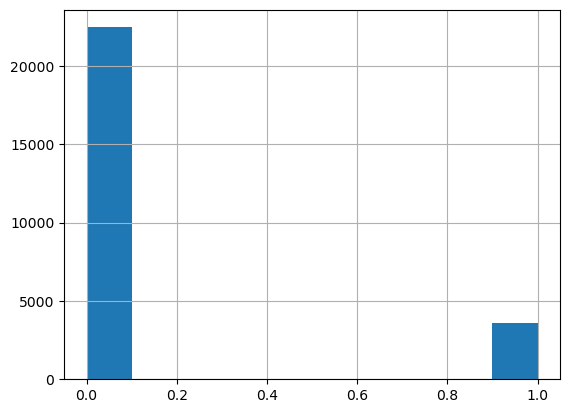

histogram for sports


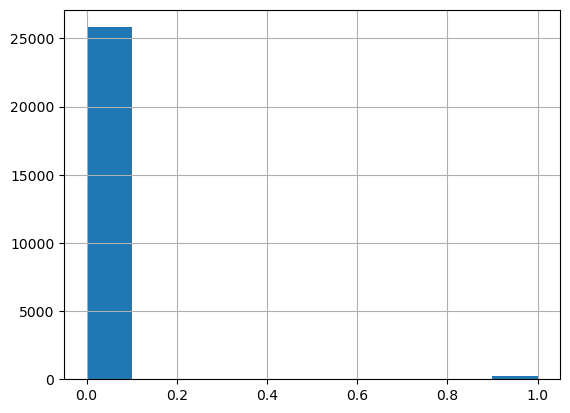

histogram for photography


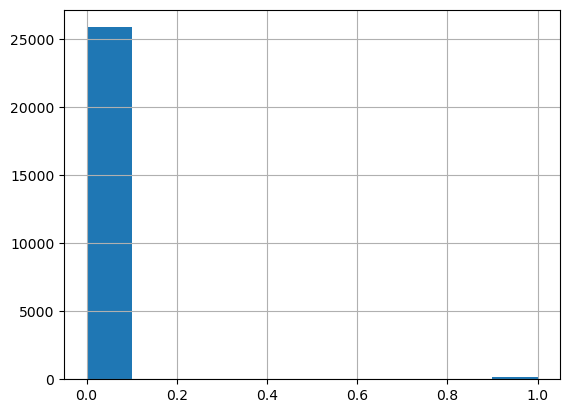

histogram for _image


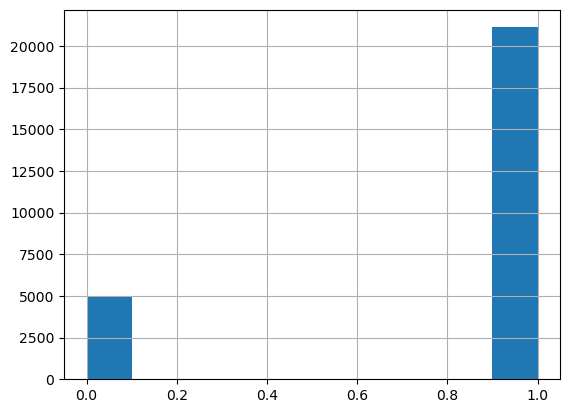

histogram for _video


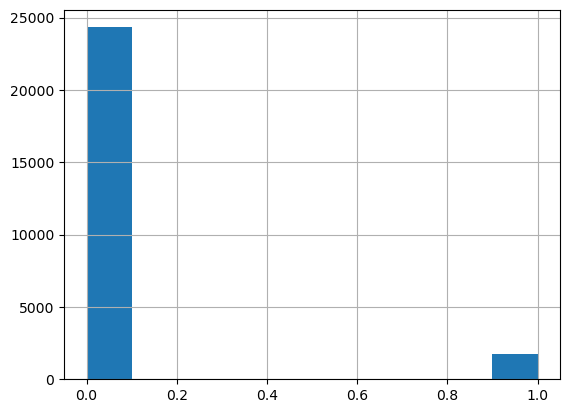

histogram for mean_sol_value


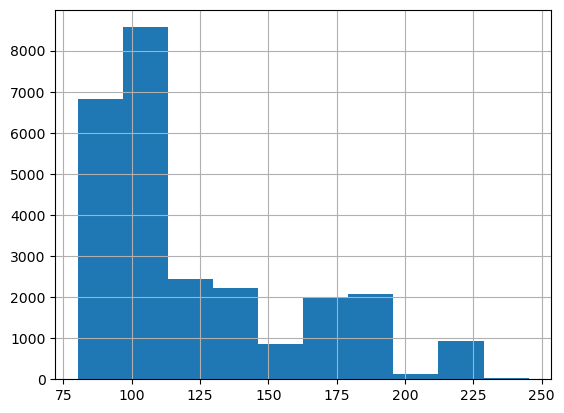

histogram for adj_price


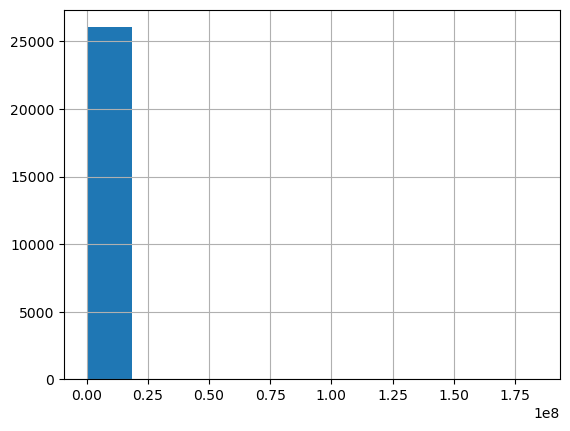

In [24]:
columns = df_1.columns.to_list()
columns.remove('img')
columns.remove('collectionName')
for i in columns:
    print(f"histogram for {i}")
    df_1[i].hist()
    plt.show()

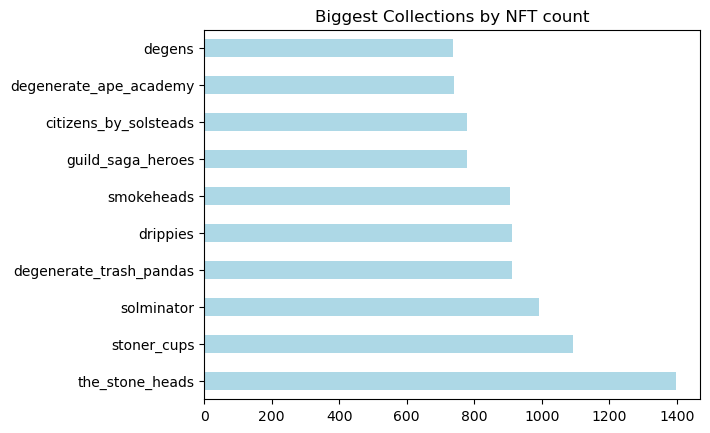

In [25]:
collections_by_nft_count = df_1['collectionName'].value_counts()[:10]
collections_by_nft_count.plot(kind='barh', color = 'lightblue')
plt.title("Biggest Collections by NFT count")
plt.show()

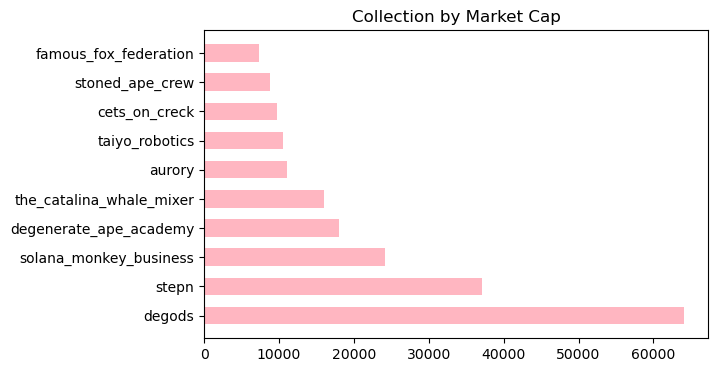

In [26]:
most_valued_collections = df5.sort_values(by=['market_cap'], ascending=False)['market_cap'][:10]
most_valued_collections_names = df5.sort_values(by=['market_cap'], ascending=False)['collectionName'][:10]
fig, ax = plt.subplots(figsize =(6.5,4))

# Horizontal Bar Plot
ax.barh(most_valued_collections_names.values, most_valued_collections.values, height=0.6, color = 'lightpink')
plt.title("Collection by Market Cap")
plt.show()

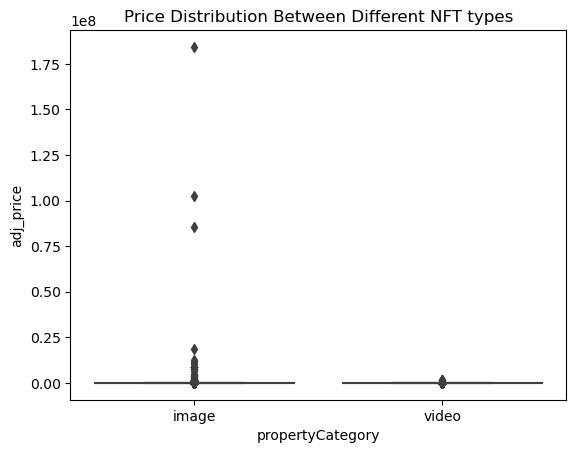

In [27]:
sns.boxplot(x="propertyCategory", y="adj_price", data=propertyCategory_df)
plt.title('Price Distribution Between Different NFT types')
plt.show()

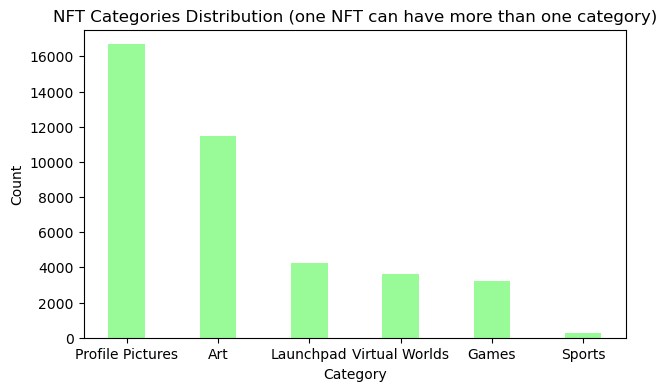

In [28]:
fig = plt.figure( figsize =(7,4))
values = [df_1.pfps.sum(), df_1.art.sum(), df_1.launchpad.sum(), df_1.games.sum(),  df_1.virtual_worlds.sum(),df_1.sports.sum()]
categories = ['Profile Pictures', 'Art', 'Launchpad', 'Virtual Worlds', 'Games', 'Sports']
plt.bar(categories, values, color ='palegreen',
        width = 0.4)
plt.title('NFT Categories Distribution (one NFT can have more than one category)')
plt.xlabel('Category')
plt.ylabel('Count')
plt.show()

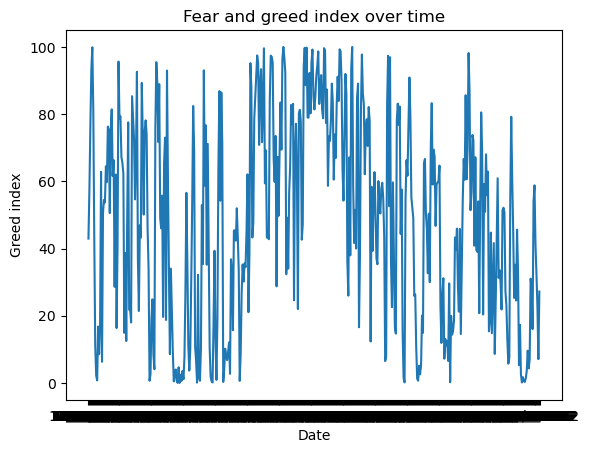

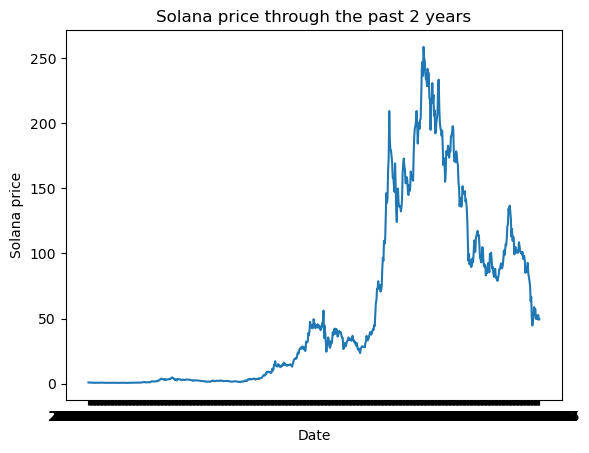

In [29]:
df_greed =pd.read_csv(r"sen.csv")

y=df_greed['fear_greed_index']
x=df_greed['date']
plt.ylabel("Greed index")
plt.xlabel("Date")
plt.title("Fear and greed index over time")
plt.plot(x,y)
plt.show()


df_sol = pd.read_csv("SOL-USD (1).csv")



x= df_sol['Date']
y=df_sol['Open']
plt.plot(x,y)
plt.xlabel("Date")
plt.ylabel("Solana price")
plt.title("Solana price through the past 2 years")
plt.show()

#### The 100 most expensive NFTs

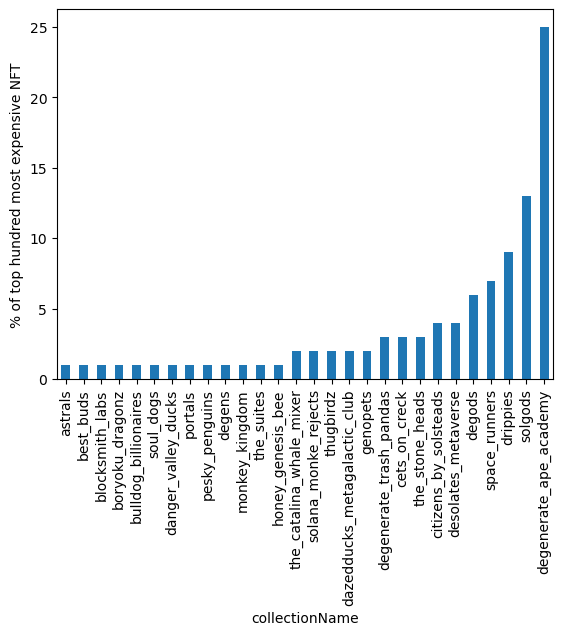

In [30]:
top_hundred = df_1.nlargest(100, 'adj_price')
collections = top_hundred.groupby(['collectionName']).size()
collections.sort_values().plot.bar()
plt.ylabel("% of top hundred most expensive NFT")
plt.title("")
plt.show()

The most expenxive NFT cost 184269354$ but google says the most expensive NFT is cost 91M$, here's its photo
https://metadata-temp-api.spacerunners.com/images/675


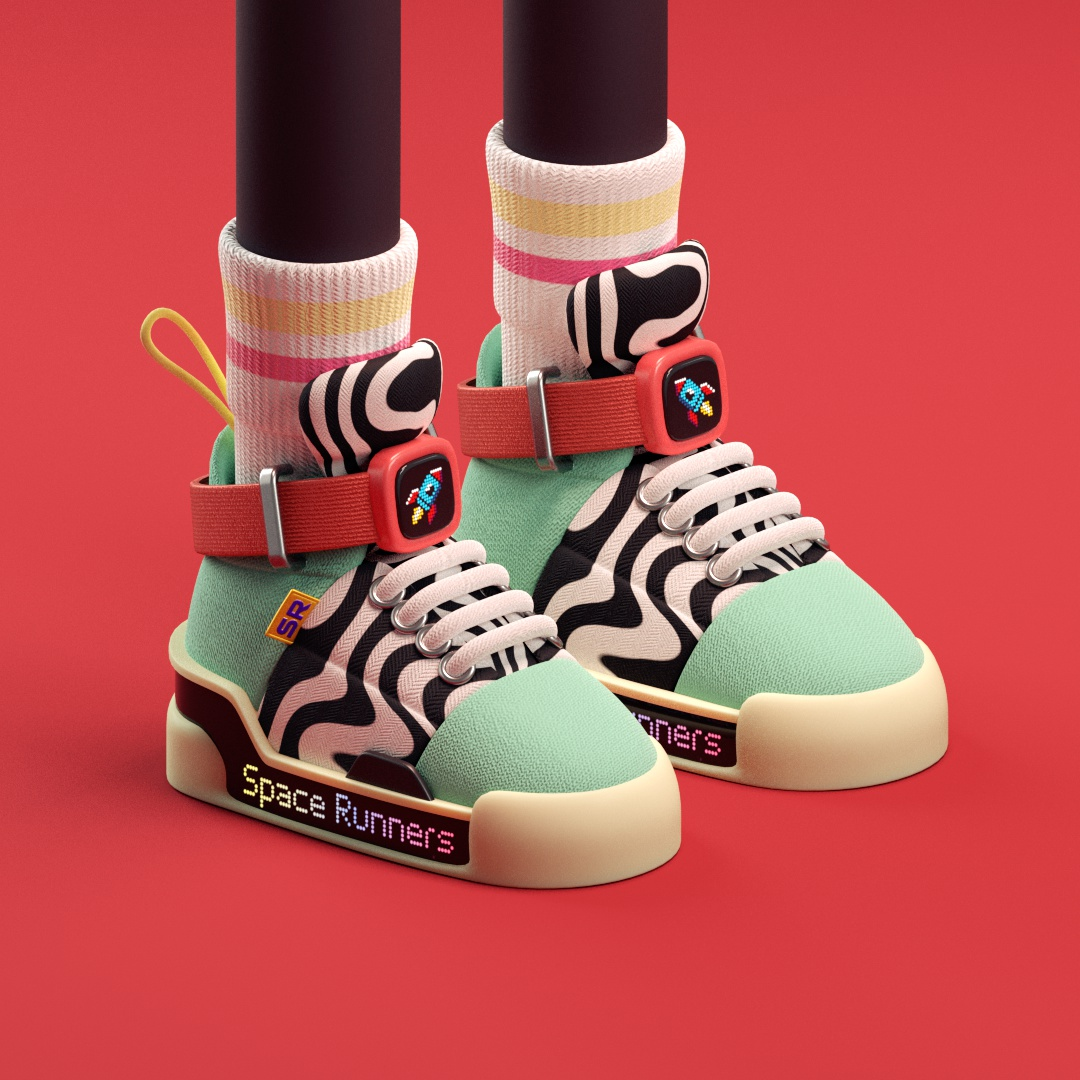

In [31]:
most_exp_nft = df_1.adj_price.max()
row = df_1[df_1.adj_price == most_exp_nft]
print(f"The most expenxive NFT cost {int(most_exp_nft)}$ but google says the most expensive NFT is cost 91M$, here's its photo")
print(row.img.to_list()[0])
from IPython import display
display.Image("675.jpg", width = 400)

The least expenxive NFT cost 46$ , here's its photo


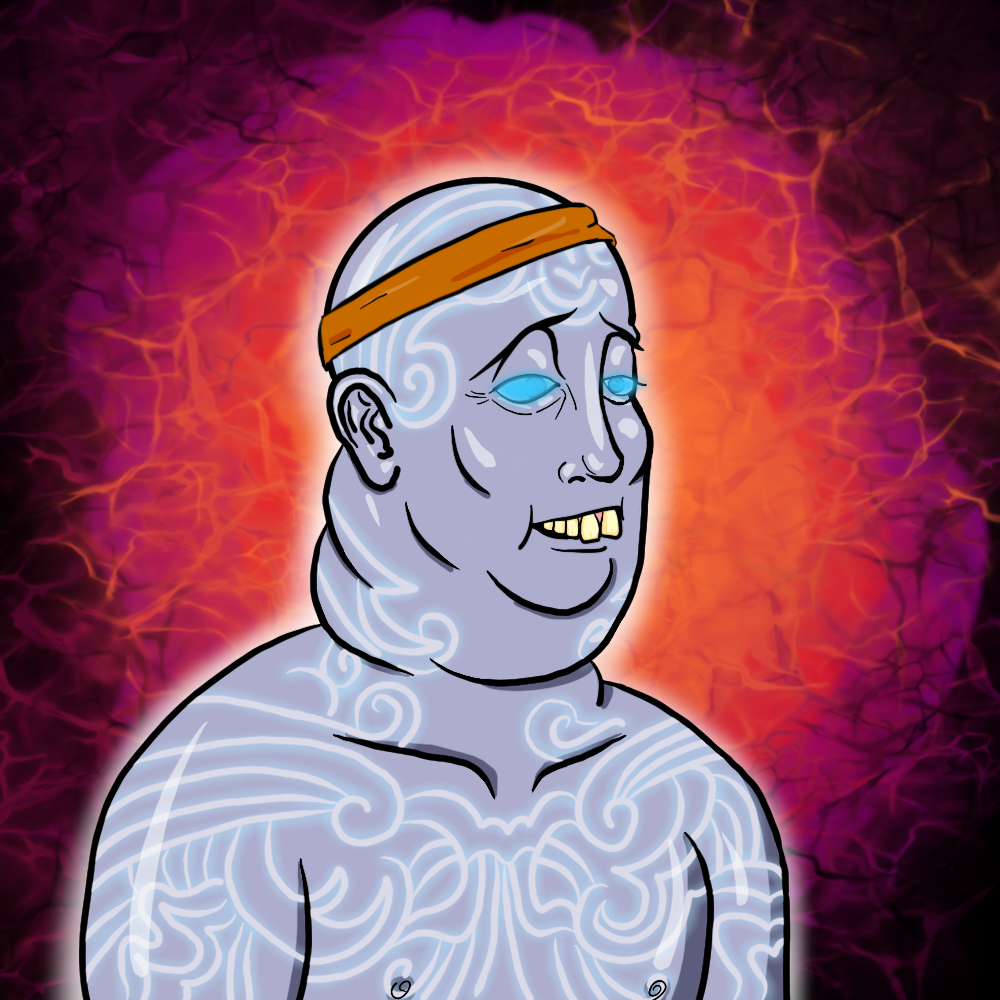

In [32]:
least_exp_nft = df_1.adj_price.min()
row = df_1[df_1.adj_price == least_exp_nft]
print(f"The least expenxive NFT cost {int(least_exp_nft)}$ , here's its photo")
row.img.to_list()[0]
display.Image("743.png", width = 400)

### Outlier detection 
After getting pretty lame result, we figured out there is a HUGE variancr between adjested price values. <br> Meaning we need to drop some columns with high price values

count       26063.00000
mean        30025.29920
std       1434070.53871
min            46.29007
25%           341.71060
50%           909.13479
75%          3115.96434
max     184269354.73046
Name: adj_price, dtype: float64


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


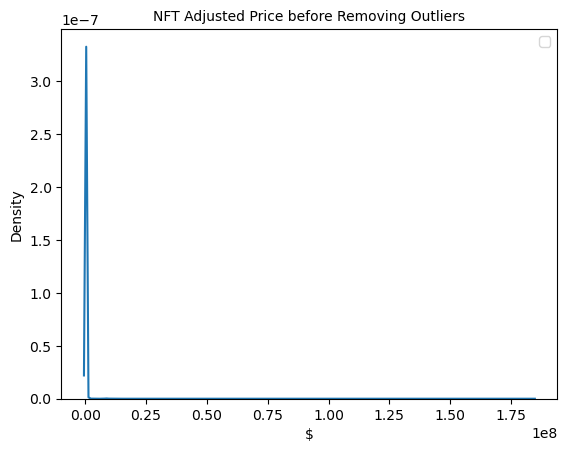

In [33]:
#plotting the target distribution after removing outliers
pd.set_option('display.float_format', lambda x: '%.5f' % x)
print(df_1['adj_price'].describe())
sns.kdeplot(df_1['adj_price'])
plt.title("NFT Adjusted Price before Removing Outliers", fontsize=10)
plt.legend()
plt.xlabel("$")
plt.show()

In [34]:
def is_outlier_by_quantile(x, q):
  if x>q:
    return True
  else:
    return False

quant = df_1['adj_price'].quantile(0.95)
mask2 =  df_1['adj_price'].apply(is_outlier_by_quantile, q=quant)

In [35]:
rows= len(df_1)
df_1 = df_1[~mask2]
print(f"Outlier detection removed {rows - len(df_1)} rows")

Outlier detection removed 1302 rows


count   24761.00000
mean     2624.50780
std      4477.80503
min        46.29007
25%       315.73390
50%       845.61319
75%      2469.86658
max     27126.29820
Name: adj_price, dtype: float64


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


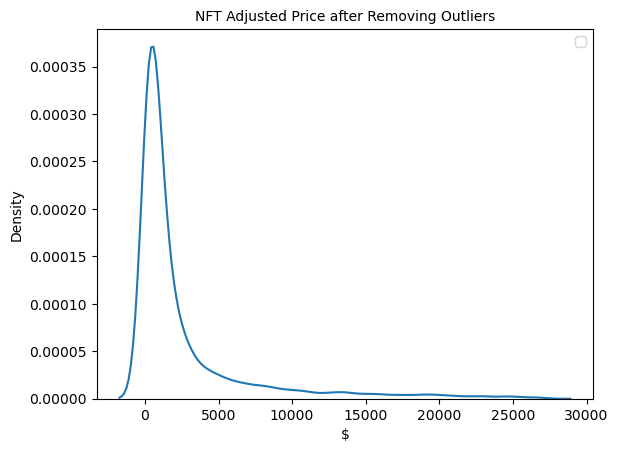

In [36]:
#plotting the target distribution after removing outliers
pd.set_option('display.float_format', lambda x: '%.5f' % x)
print(df_1['adj_price'].describe())
sns.kdeplot(df_1['adj_price'])
plt.title("NFT Adjusted Price after Removing Outliers", fontsize=10)
plt.legend()
plt.xlabel("$")
plt.show()

It is much harder to calculate visual featu

In [37]:
df_1 = df_1.drop(df_1[df_1._video == 1].index)

In [38]:
def is_gif(x):
  if "gif" in x:
    return True
  else:
    return False

mask3 =  df_1['img'].apply(is_gif)
df_1 = df_1[~mask3]

## Visual Features

In [39]:
df_1['img brightness'] = np.nan
df_1['img colorfulness'] = np.nan
df_1['img contrast'] = np.nan

In [40]:
'''
super long run-time (12+ hours)

def calculate_brightness(image):
    greyscale_image = image.convert('L')
    histogram = greyscale_image.histogram()
    pixels = sum(histogram)
    brightness = scale = len(histogram)

    for index in range(0, scale):
        ratio = histogram[index] / pixels
        brightness += ratio * (-scale + index)

    return 1 if brightness == 255 else brightness / scale

def calculate_colorfulness(image):
    image = np.array(image)
    # split the image into its respective RGB components
    (R, G, B) = cv2.split(image.astype("float"))
    # compute rg = R - G
    rg = np.absolute(R - G)
    # compute yb = 0.5 * (R + G) - B
    yb = np.absolute(0.5 * (R + G) - B)
    # compute the mean and standard deviation of both `rg` and `yb`
    (rbMean, rbStd) = (np.mean(rg), np.std(rg))
    (ybMean, ybStd) = (np.mean(yb), np.std(yb))
    # combine the mean and standard deviations
    stdRoot = np.sqrt((rbStd ** 2) + (ybStd ** 2))
    meanRoot = np.sqrt((rbMean ** 2) + (ybMean ** 2))
    # derive the "colorfulness" metric and return it
    return stdRoot + (0.3 * meanRoot)

def calculate_contrast(image):
    open_cv_image = np.array(image) 
    # Convert RGB to BGR 
    open_cv_image = open_cv_image[:, :, ::-1].copy()
    img_grey = cv2.cvtColor(open_cv_image, cv2.COLOR_BGR2GRAY)
    return img_grey.std()

df_1 = pd.read_csv("out.csv")
ix = int(df_1.iloc[0]["last_index"])
print(df_1.at[0, "last_index"])

for index in tqdm(range(ix,len(df_1))):
    try:
        imgURL = df_1['img'].iloc[index]
        response = requests.get(imgURL)
        img = PIL.Image.open(BytesIO(response.content))
        rgb_image = img.convert('RGB')
        df_1['img brightness'].iloc[index] = calculate_brightness(rgb_image)
        df_1['img colorfulness'].iloc[index] = calculate_colorfulness(rgb_image)
        df_1['img contrast'].iloc[index] = calculate_contrast(rgb_image)
    except:
        pass
    if index%50 == 0:
        df_1.at[0, "last_index"] = index
        df_1.to_csv('out.csv')
        
df_1.to_csv('out.csv')
df_1.drop("last_index", axis =1, inplace = True)
'''

'\nsuper long run-time (12+ hours)\n\ndef calculate_brightness(image):\n    greyscale_image = image.convert(\'L\')\n    histogram = greyscale_image.histogram()\n    pixels = sum(histogram)\n    brightness = scale = len(histogram)\n\n    for index in range(0, scale):\n        ratio = histogram[index] / pixels\n        brightness += ratio * (-scale + index)\n\n    return 1 if brightness == 255 else brightness / scale\n\ndef calculate_colorfulness(image):\n    image = np.array(image)\n    # split the image into its respective RGB components\n    (R, G, B) = cv2.split(image.astype("float"))\n    # compute rg = R - G\n    rg = np.absolute(R - G)\n    # compute yb = 0.5 * (R + G) - B\n    yb = np.absolute(0.5 * (R + G) - B)\n    # compute the mean and standard deviation of both `rg` and `yb`\n    (rbMean, rbStd) = (np.mean(rg), np.std(rg))\n    (ybMean, ybStd) = (np.mean(yb), np.std(yb))\n    # combine the mean and standard deviations\n    stdRoot = np.sqrt((rbStd ** 2) + (ybStd ** 2))\n    

In [41]:
df_1 = pd.read_csv("out.csv")

In [42]:
df_1.drop(['Unnamed: 0.2','Unnamed: 0.1','Unnamed: 0'], axis=1, inplace=True)

In [43]:
#correlation matrix
rho = df_1.corr()
rho.style.background_gradient(cmap='coolwarm')

## Pairs of Correlated Features 

In [44]:
corr = rho[rho>=0.5]
corr = corr.abs()
corr = (corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))
                  .stack()
                  .sort_values(ascending=False))
corr

total_supply              count                      1.00000
High                      mean_sol_value             0.99858
Low                       mean_sol_value             0.99751
Adj Close                 mean_sol_value             0.99745
High                      Adj Close                  0.99725
                          Low                        0.99472
Low                       Adj Close                  0.99418
price                     adj_price                  0.94306
floor_price               thirty_day_average_price   0.90079
thirty_day_volume         total_volume               0.87507
average_price             thirty_day_average_price   0.83508
floor_price               market_cap                 0.82866
thirty_day_average_price  total_volume               0.81937
market_cap                thirty_day_average_price   0.81166
num_owners                count                      0.77732
total_supply              num_owners                 0.77732
floor_price             

We can see that in the above plot that we still have a left tail normal distribution after cutting of the outliers. But it is less extreme

### The Brightest NFT

['https://arweave.net/cZ4bRw7-9SJxnMVB8YL5qKl6r0MEAjWEq2J26K4qw3E?ext=png']


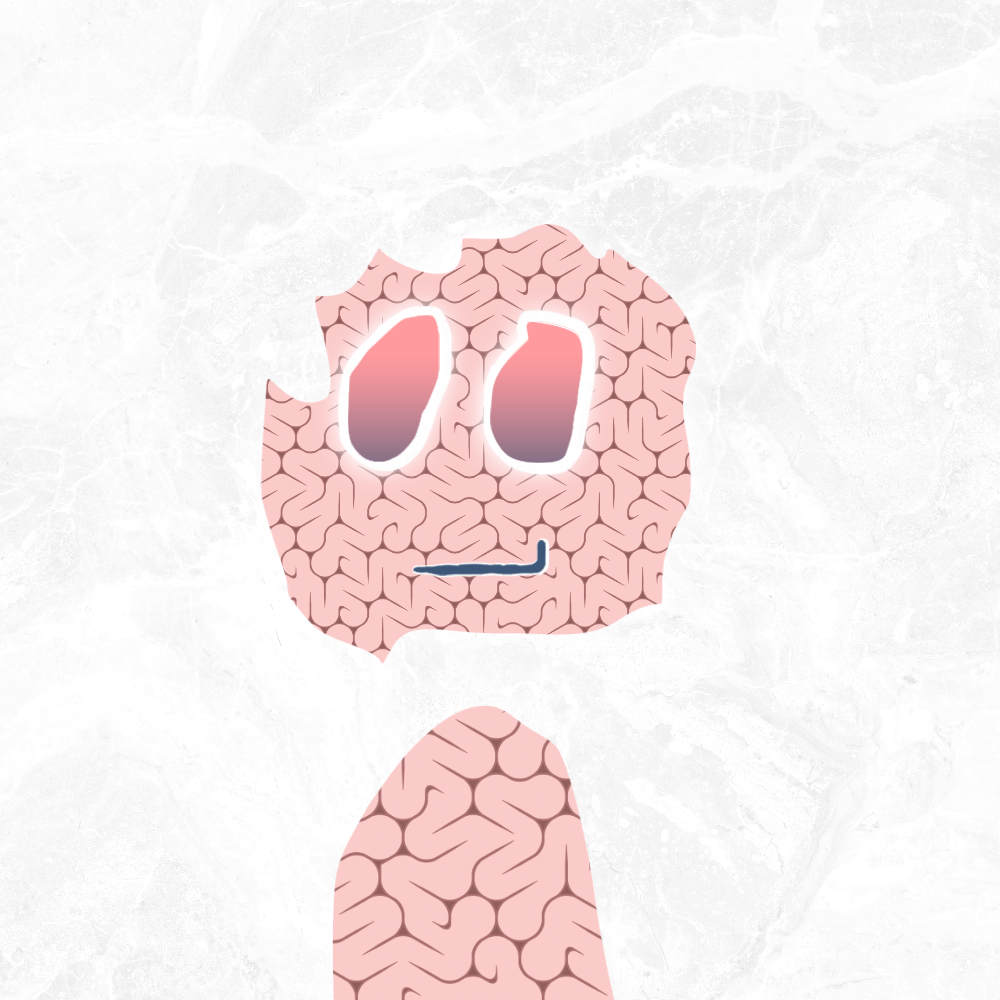

In [45]:
max_brightness = df_1['img brightness'].max()
row = df_1[df_1['img brightness'] == max_brightness]
print(row.img.to_list())
display.Image("cZ4bRw7-9SJxnMVB8YL5qKl6r0MEAjWEq2J26K4qw3E.png", width=400)

### The Darkest NFT

['https://arweave.net/K3afvP2QJhYn-NFfv1zQekBybuusfLcIaJyiPJbz8wI?ext=png']


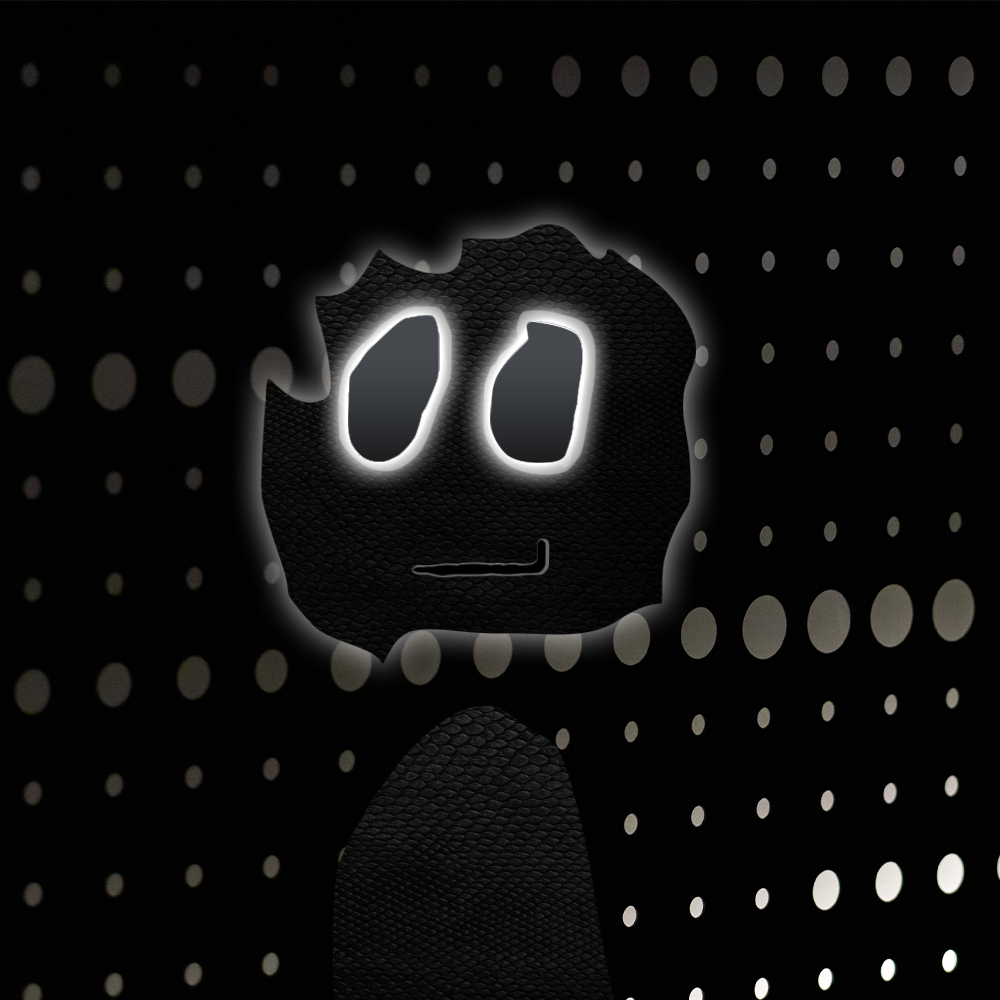

In [46]:
min_brightness = df_1['img brightness'].min()
row = df_1[df_1['img brightness'] == min_brightness]
print(row.img.to_list())
display.Image("K3afvP2QJhYn-NFfv1zQekBybuusfLcIaJyiPJbz8wI.png", width=400)

In [48]:
df_1.drop(['img', 'High', 'Low', 'mean_sol_value'] , axis = 1, inplace = True)

In [49]:
# Seperating target and the feature that used in its convertion and splitting dataset into train and test

y = df_1['adj_price'].copy()

df_1.drop(['price','adj_price','Adj Close'] , axis = 1, inplace=True)

X_train, X_test, y_train, y_test = train_test_split(df_1, y, test_size = 0.2, random_state = 47)
print("X_train has", len(X_train), " rows")
print("X_test has", len(X_test), " rows")
print("y_train has", len(y_train), " rows")
print("y_test has", len(y_test), " rows")

X_train has 18280  rows
X_test has 4571  rows
y_train has 18280  rows
y_test has 4571  rows


In [50]:
print("In the end of the pre-processing stage we have", len(X_train), "rows and ", len(X_train.columns), "columns")

In the end of the pre-processing stage we have 18280 rows and  34 columns


In [51]:
# We created a special transformer to handle missing values so we can fit it on the train set values and then transform the train&test sets  
from sklearn.base import TransformerMixin
from scipy.sparse import csr_matrix
from scipy.sparse import hstack as sparse_hstack
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import FeatureUnion
import numpy as np
import pandas as pd

class numeric_Transformer(TransformerMixin):
    '''
    Imputes all numeric columns with their medians on the training set.
    Parameters
    ----------
    None
    Returns
    ----------
    Sparse Matrix
            Matrix consisting of the numeric columns after imputation
            
    '''

    
    def __init__(self):
        self.numeric_features = X_train.columns
        self.num_medians = np.zeros(len(X_train.columns))

    def fit(self, X, y=None):
        '''
        Learn the median values of the numeric columns
        Parameters
        ----------
        None
        Returns
        ----------
        self
        ''' 
        X = X.copy()
        self.num_medians = X.median()
        return self
    
    def transform(self, X, y=None):
        '''
        Transforms all anon numeric to a sparse matrix
        Parameters
        ----------
        None
        Returns
        ----------
        Sparse Matrix
            Matrix consisting of all numeric features after imputation with median values
        '''   
        X_copy = X.copy()        
        for col in X_copy:
            X_copy[col].fillna(self.num_medians[col], inplace=True)

        return X_copy
    
    def get_feature_names(self):
        '''
        returns a list of feature names consisting of each of the numeric_features.
        Parameters
        ----------
        None
        Returns
        ----------
        List
            A list of feature names
        '''   
        return [x.lower() for x in self.numeric_features]    

In [52]:
pd.set_option('display.max_columns', None)
numeric_transformer = numeric_Transformer()
print(numeric_transformer)
numeric_transformer.fit(X_train)
x_train = numeric_transformer.transform(X_train)
x_test =numeric_transformer.transform(X_test)

In [53]:
# We scaled the featurs to have mean = 0, std = 1. So that the scale won't be a factor in neigbor-based/distance-based algorithms.
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(x_train)
scaler.transform(x_train)
scaler.transform(x_test)


'\nmean_y = y_train.mean()\nstd_y = y_train.std()\n\ny_train = y_train.apply(lambda x: (x-mean_y)/std_y)\ny_test = y_test.apply(lambda x: (x-mean_y)/std_y)\n'

Models Building

In [55]:
mean_value = DummyRegressor(strategy='mean')
knn=KNeighborsRegressor()
svr=SVR()
lr=LinearRegression()
dt=DecisionTreeRegressor(criterion='absolute_error')
gbm=GradientBoostingRegressor()
ada=AdaBoostRegressor()
rfr=RandomForestRegressor()
xgb=XGBRegressor()

models=[]
models.append(('MeanValue', mean_value))
models.append(('KNeighborsRegressor',knn))
models.append(('SVR',svr))
models.append(('LinearRegression',lr))
models.append(('DecisionTreeRegressor',dt))
models.append(('GradientBoostingRegressor',gbm))
models.append(('AdaBoostRegressor',ada))
models.append(('RandomForestRegressor',rfr))
models.append(('XGBRegressor',xgb))

from sklearn.metrics import r2_score,mean_squared_error
from sklearn.model_selection import train_test_split,cross_val_score

Model=[]
rmse=[]
mae = []
cv=[]

for name,model in models:
    Model.append(name)
    model.fit(x_train,y_train)
    pre=model.predict(x_test)
    mean_ab_err = mean_absolute_error(y_test, pre)
    mae.append(mean_ab_err)
    sc=cross_val_score(model,x_train,y_train,cv=5,scoring='r2').mean()
    cv.append(sc*100)
    rmsescore=np.sqrt(mean_squared_error(y_test,pre))
    rmse.append(rmsescore)
result=pd.DataFrame({'Model':Model,'RMSEscore':rmse,'Cross_val_score':cv, 'Mean absulote error': mae})
result


Model  RMSEscore  Cross_val_score  Mean absulote error
0                  MeanValue 4535.12647         -0.02330           2872.12603
1        KNeighborsRegressor 2743.24806         63.60902           1339.83993
2                        SVR 4855.88846        -14.13758           2285.72067
3           LinearRegression 2642.29214         65.79537           1439.52533
4      DecisionTreeRegressor 3633.24587         36.78836           1650.36630
5  GradientBoostingRegressor 2554.46231         68.54369           1273.64624
6          AdaBoostRegressor 2920.68390         57.11419           1923.12096
7      RandomForestRegressor 2664.76023         65.14008           1309.40342
8               XGBRegressor 2639.92655         65.82225           1302.21666

## Hyperparameter Tuning for the Best Models

Random Forest Regressor

In [ ]:
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 1000, num = 100)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]

random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rfr, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=10, random_state=42, scoring = 'neg_mean_absolute_error')
# Fit the random search model
rf_random.fit(x_train, y_train)               

In [57]:
clf = rf_random.best_estimator_
y_pred = clf.predict(x_test)
np.sqrt(mean_squared_error(y_test, y_pred))
mean_absolute_error(y_test, y_pred)


1255.3020721199741

XBB Regressor

In [ ]:
xgb=XGBRegressor()
search_grid={'n_estimators':[500,1000,2000],'learning_rate':[.001,0.01,.1],'random_state':[1]}
search=RandomizedSearchCV(estimator=ada,param_distributions=search_grid, n_iter = 100, cv = 3, verbose=10, random_state=42, scoring = 'neg_mean_absolute_error', error_score='raise')
search.fit(x_train, y_train)

In [59]:
clf = search.best_estimator_
y_pred = clf.predict(x_test)
np.sqrt(mean_squared_error(y_test, y_pred))
mean_absolute_error(y_test, y_pred)

1454.8377362179772

Gradient Boosting Regressor

In [ ]:
parameters = {'learning_rate': [0.01,0.02,0.03,0.04],
                  'subsample'    : [0.9, 0.5, 0.2, 0.1],
                  'n_estimators' : [100,500,1000, 1500],
                  'max_depth'    : [4,6,8,10]
                 }

gbr = RandomizedSearchCV(estimator=gbm, param_distributions= parameters, n_iter = 100, cv = 3, verbose=10, random_state=42, scoring = 'neg_mean_absolute_error')
gbr.fit(x_train, y_train)

In [61]:
clf = gbr.best_estimator_
y_pred = clf.predict(x_test)
np.sqrt(mean_squared_error(y_test, y_pred))
mean_absolute_error(y_test, y_pred)

1253.8166222722916

Decision Tree regressor

In [ ]:
dt=DecisionTreeRegressor(criterion='absolute_error')
parameters = {'max_depth'    : [5, 10, 20, None],
                  'min_samples_split' : [2,7,10],
                  'max_features' : ['auto', 'sqrt', 'log2']
                 }

random_tree = RandomizedSearchCV(estimator=dt, param_distributions= parameters, n_iter = 100, cv = 3, verbose=10, random_state=42, scoring = 'neg_mean_absolute_error', error_score='raise')
random_tree.fit(x_train, y_train)

In [63]:
clf = random_tree.best_estimator_
clf

DecisionTreeRegressor(criterion='absolute_error', max_depth=5,
                      max_features='auto', min_samples_split=7)

In [64]:
y_pred = clf.predict(x_test)
np.sqrt(mean_squared_error(y_test, y_pred))
mean_absolute_error(y_test, y_pred)

1139.840899866029

The best model is the decision Tree!

In [65]:
arr1 = pd.Series(y_test.values)
arr2 = pd.Series(clf.predict(x_test))

In [66]:
res = pd.concat([arr1,arr2], axis=1)
res.rename(columns={0: 'ground_truth', 1: 'prediction'}, inplace= True)

In [67]:
res

ground_truth  prediction
0        627.30301   427.82371
1        191.35054   246.77809
2       1261.89014  1828.80377
3        181.82696   427.82371
4      16369.02675 19841.24454
...            ...         ...
4566   12192.02516  1828.80377
4567     486.31855   427.82371
4568    5698.61188  6134.49607
4569     977.28566   807.36036
4570     888.21190   807.36036

[4571 rows x 2 columns]

## Final thoughts

The NFT phenomenon is relatively new and there are not many studies and works in this field. Therefore, it was not possible to know what the most suitable data are for predicting the price. As a result, all the features we introduced into the model are based on little research and internal logic. Note that no Kaggle jobs were published on the database I used.
I believe that by adding additional explanatory features (mainly individual features on the properties), and by adding current statistical information on the collections, I will be able to improve the predictive ability of the model.